## Notebook02a Purpose: Analysis of Baseline

This notebook analyzes the baseline BART model trained in Notebook 02:
1. Visualize learning curves to verify successful training
2. Generate qualitative examples to inspect model outputs

 **Guardrail #8** (Analysis of findings) from the project requirements.

In [ ]:

import os
import json
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, set_seed
from google.colab import drive


drive.mount('/content/drive')


PROJECT_ROOT = "/content/drive/MyDrive/w266_project_final"
CONFIGS_DIR = os.path.join(PROJECT_ROOT, "configs")
CONFIG_PATH = os.path.join(CONFIGS_DIR, "baseline.json")

with open(CONFIG_PATH, 'r') as f:
    cfg = json.load(f)
print("Loaded config from:", CONFIG_PATH)


DATA_DIR = os.path.join(PROJECT_ROOT, "data")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, cfg['train']['output_dir'])
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
METRICS_FILE = os.path.join(RESULTS_DIR, "baseline_bart_20k_metrics.json")
SNAPSHOT_DIR = os.path.join(DATA_DIR, "snapshots/cnndm_tok_bart_base")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Mounted at /content/drive
Loaded config from: /content/drive/MyDrive/w266_project_final/configs/baseline.json
Using device: cpu


Loading metrics artifact from: /content/drive/MyDrive/w266_project_final/results/baseline_bart_20k_metrics.json
Found 37 training steps and 3 evaluation steps.


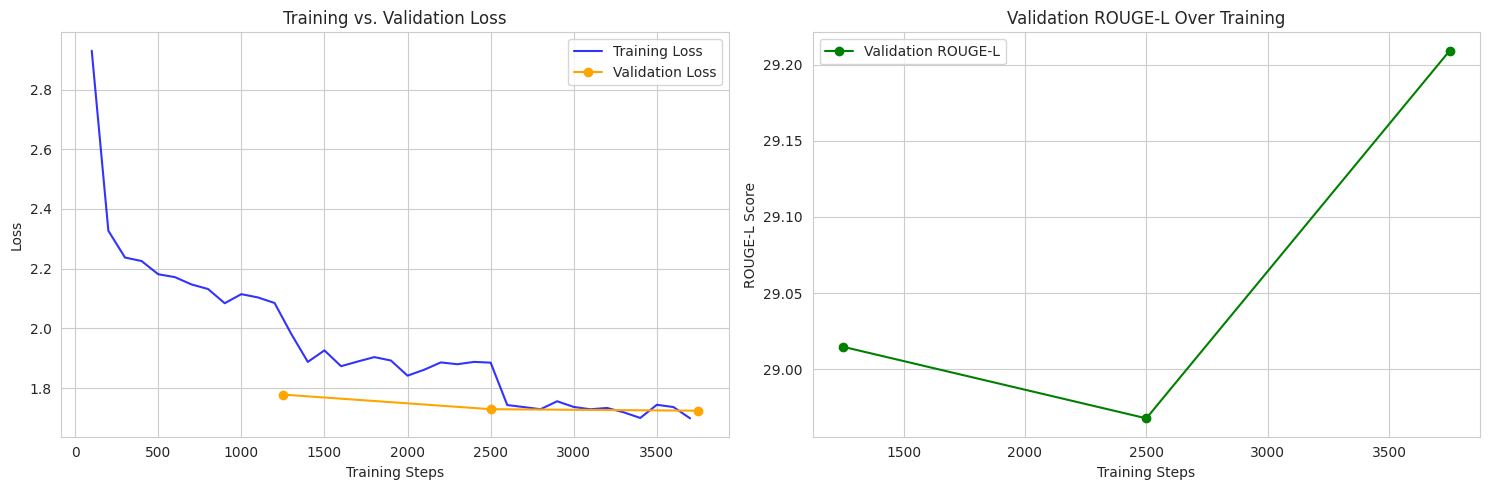

In [ ]:

# Metrics
print(f"Loading metrics artifact from: {METRICS_FILE}")

with open(METRICS_FILE, 'r') as f:
    metrics = json.load(f)

log_history = metrics['log_history']

# Parse Log History
train_stats = []
eval_stats = []

for entry in log_history:
    if 'loss' in entry: # training step
        train_stats.append({
            'step': entry['step'],
            'epoch': entry['epoch'],
            'loss': entry['loss']
        })
    if 'eval_loss' in entry: # evaluation step
        eval_stats.append({
            'step': entry['step'],
            'epoch': entry['epoch'],
            'eval_loss': entry['eval_loss'],
            'eval_rougeL': entry['eval_rougeL']
        })

df_train = pd.DataFrame(train_stats)
df_eval = pd.DataFrame(eval_stats)

print(f"Found {len(df_train)} training steps and {len(df_eval)} evaluation steps.")

#  Plots
plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(df_train['step'], df_train['loss'], label='Training Loss', color='blue', alpha=0.8)
plt.plot(df_eval['step'], df_eval['eval_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training vs. Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Validation ROUGE-L Score
plt.subplot(1, 2, 2)
plt.plot(df_eval['step'], df_eval['eval_rougeL'], label='Validation ROUGE-L', color='green', marker='o')
plt.title('Validation ROUGE-L Over Training')
plt.xlabel('Training Steps')
plt.ylabel('ROUGE-L Score')
plt.legend()

plt.tight_layout()
plt.show()

## Learning Curve Results

**Key Observations:**

1. **Training Loss** (blue line): Decreases steadily from ~2.8 to ~1.7 over 3,750 training steps. This indicates the model is successfully learning to generate summaries.

2. **Validation Loss** (orange line): Decreases from ~1.78 to ~1.72, tracking closely with training loss. The small gap between training and validation loss supports there is **no overfitting**.

3. **ROUGE-L Score**: Improves from ~29.0 to ~29.2 over training. Confirming that the model is producing higher-quality summaries as training progresses.

**Conclusion:** The baseline BART model trained successfully with no signs of overfitting. The model is ready for candidate generation in Notebook 03.

In [ ]:

# Show the Fine-tuned MOdel
print(f"Loading fine-tuned model from: {CHECKPOINT_DIR}")
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT_DIR).to(device)
model.eval()

print("Loading data snapshot...")

#  HF_CACHE_DIR for dataset loading

HF_CACHE_DIR = os.path.join(DATA_DIR, "hf_cache")

# 3 sample summaries
print("Generating 3 sample summaries...")

# Load the original 'article' and 'highlights'
raw_dataset = load_dataset(
    cfg["dataset_name"],
    cfg["dataset_config"],
    split="validation",
    cache_dir=HF_CACHE_DIR
)

# Get 3 random indices from the raw validation set
import random
indices = random.sample(range(len(raw_dataset)), 3)

for i, idx in enumerate(indices):
    # Getting raw example using the index
    raw_example = raw_dataset[idx]
    article = raw_example[cfg['text_fields']['source']]
    reference = raw_example[cfg['text_fields']['summary']]

    # Generate summary
    inputs = tokenizer(article, max_length=1024, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=128, early_stopping=True)

    generated_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    #  Print Table
    print(f"\n--- SAMPLE {i+1} ---")
    print(f"\nARTICLE (truncated):\n{article[:700]}...\n")
    print(f"REFERENCE SUMMARY (Human):\n{reference}\n")
    print(f"GENERATED SUMMARY (Baseline B):\n{generated_summary}\n")
    print("-"*80)


Loading fine-tuned model from: /content/drive/MyDrive/w266_project_final/models/bart_base_cnn_dm_20k
Loading data snapshot...
Generating 3 sample summaries...

--- SAMPLE 1 ---

ARTICLE (truncated):
Newcastle United scouts will check on FC Sion striker Moussa Konate this weekend. The 21-year-old Senegal international first attracted English clubs' interest while playing for his country's Olympic side in 2012 where he scored five goals in four games and finished as the tournament's second top scorer. West Ham, Fulham and Aston Villa have all tracked his career at various stages and Newcastle will watch him on Sunday when Sion visit Young Boys of Berne. Newcastle United are sending their scouts to check on FC Sion striker Moussa Konate this weekend . English clubs West Ham, Fulham and Aston Villa have all tracked Konate's career at various stages . Newcastle have checked on Aleksandar Mit...

REFERENCE SUMMARY (Human):
Newcastle United scouts are to watch FC Sion striker Moussa Konate .


## Qualitative Analysis

The generated summaries from baseline model:

1. **Captures key entities**: Names, organizations, and dates are generally correct
2. **Maintains coherence**: Summaries are grammatically fluent and readable
3. **Extracts salient information**: Main points from the article are included

However, observed potential issues:
- Some summaries are more **extractive** than abstractive (copying phrases directly)
- Details may be **rearranged** in ways that could affect factual accuracy

These observations motivate reranking approach: even a well-trained model may produce candidates of varying factual quality.